# Current-based Spiking Neural Network (current-SNN)

## Install required packages

In [1]:
import numpy as np
import pylab as pl
import random
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation
import copy
import math

## Functions used for simulation

### Initialize parameters

Initialize parameters

In [44]:
def initialize_params(N, dt, iterations, beta, gamma=0, weights='homogeneous'):
    
    """ Initialize parameters.
        
    Parameters
    ----------
    N : 
    dt : 
    iterations : 
    beta : 
    weights :
    gamma:
    
    """

    t = np.arange(0, iterations) * dt
    x_est = np.zeros(iterations)                         # input estimate
    o = np.zeros((N, iterations))                        # spike trains
    voltage = np.zeros((N, iterations))                  # voltages
    D = np.ones(N)                                       # ''output kernel''
    if weights == 'homogeneous':
        D = np.ones(N) * gamma
    elif weights == 'heterogeneous':
        D = np.random.normal(1/N, 0.5, size=(N))
    T = [(weight ** 2)/2 + beta/2 for weight in D]    # threshold

    return (t, x_est, o, voltage, D, T) 

### Time varying signal

Create time varying signal

In [3]:
def time_varying_signal(c_upp=3):
    """ Initialize time varying input signal. """

    # create time-varying signal
    x = c_upp
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 1

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

### Run simulation

In [4]:
def run():
    """ Run simulation of spike coding network. """
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(D, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltages
        dVdt = -voltage[:, t - 1] + D * c[t - 1] - np.dot(D.T * D + np.identity(N) * beta, o[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]
        
        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.choice(above_threshold)

            # update spikes
            o[spike_neuron, t] = 1/dt

### Visualize results

Functions used to visualize results

In [5]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

In [6]:
def visualize(color, plot_voltage=1):
    """ Visualize results of the simulation of the spike coding network. """ 
    
    if plot_voltage == 0:
        plots = 2
    else:
        plots = N + 2
    pl.subplots(plots, 1, figsize=(8, 10))
    pl.subplots_adjust(hspace=0.7)

    # enable LaTeX
    pl.rc('text', usetex=True)

    # plot input and input estimate
    pl.subplot(plots, 1, 1)
    pl.title('Input and input estimate')
    pl.plot(x, label=r'$x$', color='black')
    pl.plot(x_est, label=r'$\hat{x}$', color='gray')
    pl.xlim(0, iterations)
    pl.legend()
    
    # plot spike trains
    pl.subplot(plots, 1, 2)
    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)   
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='Neuron %i' %i)
        pl.yticks([])
        pl.xticks([])
        pl.title('Spike train')
        pl.ylim(0, 100 * N + 100)
        pl.xlim(0, iterations)
        
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    counter = 3
    
    if plot_voltage == 1:
        # plot voltage over time
        for i in range(1, N + 1):
            neuron = i + 1
            pl.subplot(plots, 1, counter)
            pl.plot(voltage[i - 1], color=color[i - 1][:]/255, label='N%i'%i)
            pl.plot(np.arange(0, iterations), np.ones(iterations) * T[i - 1], color='gray', label='threshold')
            pl.xlim(0, iterations)
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i)
            pl.legend()
            counter = counter + 1

## Functions used to visualize additional data

### Firing rate

Initialize exponential filter for the firing rate:

$r_{k}(t) = \int^{\infty}_{0} e^{-t'/\tau} s_{k}(t - t') dt'$

In [7]:
def exponential_filter(t, tau):
    """ Exponential filter. """
    return np.exp(-t/tau)

In [8]:
def firing_rate(spike_train, filt):
    """ Compute firing rate by the convolution of exponential filter and spike train. """
    return np.convolve(spike_train, filt)

Compute and plot firing rate per neuron

In [9]:
def visualize_firing_rate():
    """ Compute and visualize firing rate of each neuron. """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1.5
    y = [exponential_filter(i, tau) for i in t]

    # initialize plots
    plots = N
    pl.subplots(plots, 1)
    pl.suptitle('Firing rate', fontsize=15)
    counter = 1

    # compute input estimate 
    for i in range(1, N+1):

        # compute firing rate
        firingrate = firing_rate(spike_trains[i - 1, :], y)

        # plot firing rate
        pl.subplot(plots, 1, counter)
        counter = counter + 1
        pl.plot(firingrate[0: iterations], color=color[i - 1][:]/255, label='N%i' %i)
        pl.ylim(0, max(firingrate) + 0.5)
        pl.legend()

### Membrane voltage

Compute voltage estimate one of two ways:

1) Computed voltage estimate using the derivative $\frac{dV_{i}}{dt} = -\frac{1}{\tau}V_{i} + D^{T}_{i} c - \sum^{N}_{k - 1} (D_{i}^{T} D_{k}) s_{k}$

2) Compute voltage estimate using a linear readout applied to the spike trains $V_{i} = D_{i}(x - \hat{x})$

In [41]:
def visualize_voltage():
    """ Compute and visualize membrane voltage of each neuron. """
    
    # compute voltage (by method 2)
    voltage2 = np.zeros((N, iterations))
    for n in range(N):
        voltage2[n, :] =  D[n] * (x - x_est)
        
    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))
    # pl.suptitle('Voltage', fontsize=15)
    for i in range(1, N+1):
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} = -\frac{1}{\tau}V_{i} + D^{T}_{i} c - \sum^{N}_{k = 1} (D_{i}^{T} D_{k}) s_{k}$',  fontsize=20)
        counter = counter + 1
        pl.plot(voltage[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = D^{T}_{i}(x - \hat{x})$', fontsize=20)
        counter = counter + 1
        pl.plot(voltage2[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.legend()

### Inpute estimate

Compute input estimate one of two ways:

1) Computed input estimate using the derivative $\dot{\hat{x}} = -\hat{x} + \sum^{N}_{k = 1} D_{k} s_{k}$

2) Compute input estimate using a linear readout applied to the spike trains $\hat{x} = \sum^{N}_{k = 1} D_{k} r_{k}$

In [48]:
def visualize_estimate():
    """ Plot estimate of the input signal. """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 100] = 1

    # initialize exponential filter
    tau = 1
    y = [exponential_filter(i, tau) for i in t]

    # compute input estimate (by method 2)
    x_est2 = np.zeros(iterations)
    for j in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est2[j] = x_est2[j] + D[i] * firingrate[j] 

    # plot input estimates
    pl.subplots(1, 2, figsize=(14, 2))
    #pl.suptitle('Input estimate $\hat{x}$', fontsize=15)
    pl.subplot(1, 2, 1)
    pl.title('Online $\dot{\hat{x}} = -\hat{x} + \sum^{N}_{k = 1} D_{k} s_{k}$', fontsize='20')
    pl.plot(x_est, color='gray', label=r'$\hat{x}$')
    pl.plot(x, 'k', label=r'$x$')
    pl.xlabel('time')
    pl.legend()
    pl.subplot(1, 2, 2)
    pl.title('Offline $\hat{x} = \sum^{N}_{k = 1} D_{k} r_{k}$',  fontsize='20')
    pl.plot(x_est2, color='gray', label=r'$\hat{x}$')
    pl.plot(x, 'k', label=r'$x$')
    pl.xlabel('time')
    pl.legend()

## Run simulation

### $\textit{N}$-neurons (homogeneous network)

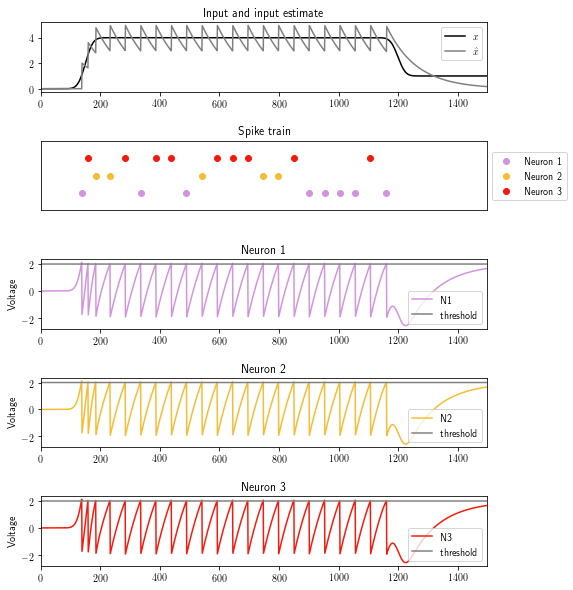

In [33]:
N = 3
dt = 0.01
iterations = 1500
c_upp = 4
gamma = 2
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors

t, x_est, o, voltage, D, T = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c = time_varying_signal(c_upp)
run()
visualize(color)

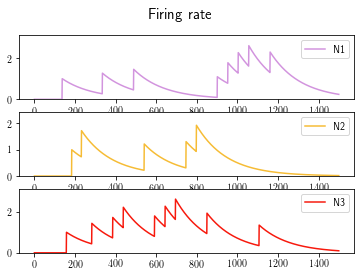

In [34]:
visualize_firing_rate()

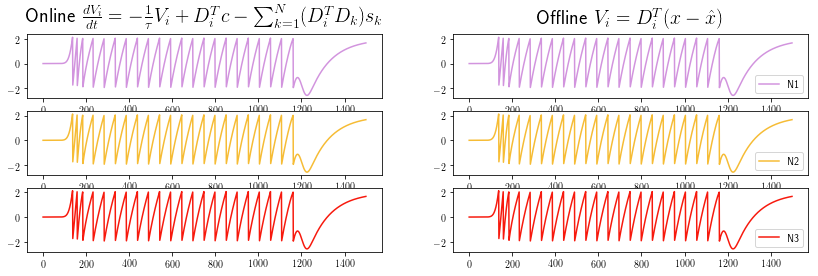

In [42]:
visualize_voltage()

### $\textit{N}$-neurons (heterogeneous network)

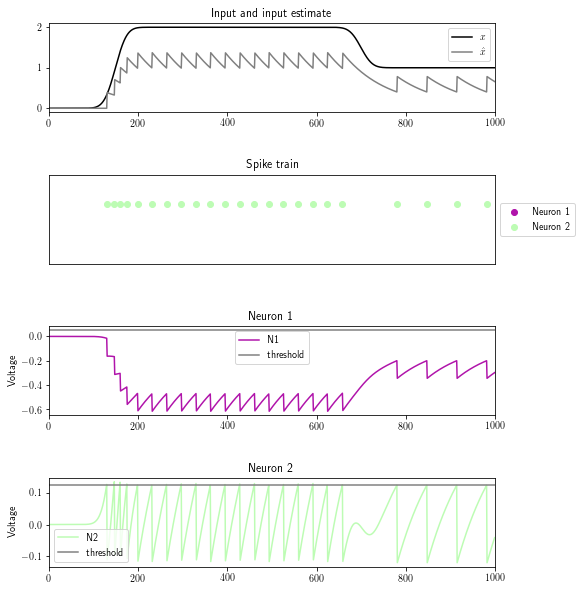

In [45]:
N = 2
dt = 0.01
iterations = 1000
c_upp = 2
gamma = 2
beta = 0.1                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors

t, x_est, o, voltage, D, T = initialize_params(N, dt, iterations, beta, gamma, 'heterogeneous')
x,c = time_varying_signal(c_upp)
run()
visualize(color)

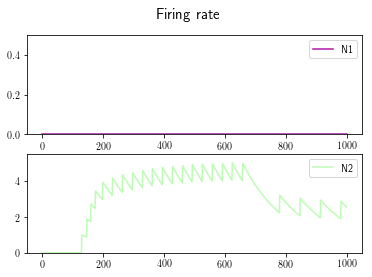

In [46]:
visualize_firing_rate()

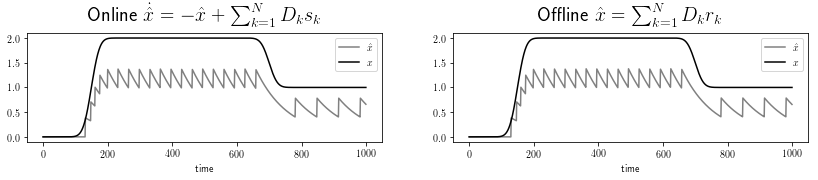

In [49]:
visualize_estimate()

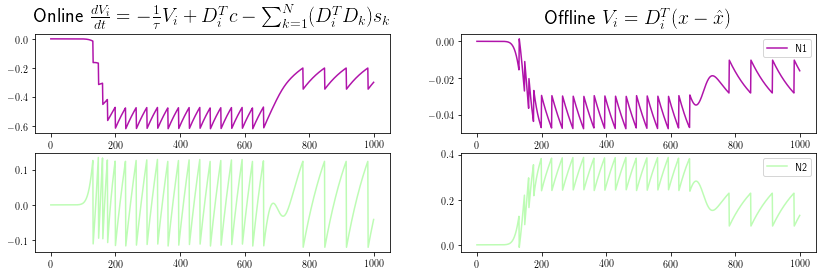

In [50]:
voltage2 = visualize_voltage()